In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting/data_lstm.csv


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization, Conv1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
df = pd.read_csv("/kaggle/input/demand-forecasting/data_lstm.csv")
df.head()

,city_id,date_int,time_block,hour,iconcode,precipitation,pressurechange,pressuremeansealevel,relativehumidity,temperature,...,visibility,winddirection,windgust,windspeed,demand,month,year,day_of_week,day_of_year,day_of_month
0,7,20240101,24,6,20.0,0.0,0.30,1017.90,93.70,9.70,...,0.13,40.0,0.0,2.50,1638.00,1,2024,0,1,1
1,7,20240101,25,7,20.0,0.0,0.45,1018.18,91.25,9.57,...,0.35,37.5,0.0,3.32,1731.75,1,2024,0,1,1
2,7,20240101,26,7,20.0,0.0,0.60,1018.45,88.80,9.45,...,0.56,35.0,0.0,4.15,1832.87,1,2024,0,1,1
3,7,20240101,27,7,20.0,0.0,0.75,1018.72,86.35,9.32,...,0.78,32.5,0.0,4.97,1932.22,1,2024,0,1,1
4,7,20240101,28,7,20.0,0.0,0.90,1019.00,83.90,9.20,...,1.00,30.0,0.0,5.80,2021.00,1,2024,0,1,1


In [7]:
df=df[df['city_id']==7]

In [8]:
df.columns

Index(['city_id', 'date_int', 'time_block', 'hour', 'iconcode',
       'precipitation', 'pressurechange', 'pressuremeansealevel',
       'relativehumidity', 'temperature', 'temperaturefeelslike', 'uvindex',
       'validtimeist', 'visibility', 'winddirection', 'windgust', 'windspeed',
       'demand', 'month', 'year', 'day_of_week', 'day_of_year',
       'day_of_month'],
      dtype='object')

In [9]:
df['Date'] =pd.to_datetime(df['date_int'],format="%Y%m%d")

In [10]:
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)

In [11]:
for lag in [1, 4, 8, 24, 48, 96,672]:
    df[f'demand_lag_{lag}'] = df['demand'].shift(lag)

weather_features = ['temperaturefeelslike', 'windspeed', 'precipitation']
for feature in weather_features:
    for lag in [1, 96]:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
for window in [4, 24, 96]:
    df[f'demand_rollmean_{window}'] = df['demand'].shift(1).rolling(window=window).mean()

# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [12]:
df=df.dropna().reset_index(drop=True)

In [14]:
df.columns

Index(['city_id', 'date_int', 'time_block', 'hour', 'iconcode',
       'precipitation', 'pressurechange', 'pressuremeansealevel',
       'relativehumidity', 'temperature', 'temperaturefeelslike', 'uvindex',
       'validtimeist', 'visibility', 'winddirection', 'windgust', 'windspeed',
       'demand', 'month', 'year', 'day_of_week', 'day_of_year', 'day_of_month',
       'Date', 'is_weekend', 'demand_lag_1', 'demand_lag_4', 'demand_lag_8',
       'demand_lag_24', 'demand_lag_48', 'demand_lag_96', 'demand_lag_672',
       'temperaturefeelslike_lag_1', 'temperaturefeelslike_lag_96',
       'windspeed_lag_1', 'windspeed_lag_96', 'precipitation_lag_1',
       'precipitation_lag_96', 'demand_rollmean_4', 'demand_rollmean_24',
       'demand_rollmean_96', 'hour_sin', 'hour_cos', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [15]:
train_df = df[(df['date_int'] >= 20240108) & (df['date_int'] <= 20250131)]
test_df = df[(df['date_int'] >= 20250201) & (df['date_int'] <= 20250228)]

In [16]:
model_data = train_df[train_df['city_id']==7]
model_data_test = test_df[test_df['city_id']==7]

In [17]:
model_data

,city_id,date_int,time_block,hour,iconcode,precipitation,pressurechange,pressuremeansealevel,relativehumidity,temperature,...,precipitation_lag_96,demand_rollmean_4,demand_rollmean_24,demand_rollmean_96,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,7,20240108,1,1,31.0,0.0,-0.050,1019.58,77.22,10.70,...,0.0,1494.9400,1854.376250,1791.175521,2.588190e-01,0.965926,0.000000,1.000000,0.5,0.866025
1,7,20240108,2,1,31.0,0.0,-0.100,1019.55,76.65,10.60,...,0.0,1411.8950,1819.399583,1789.281771,2.588190e-01,0.965926,0.000000,1.000000,0.5,0.866025
2,7,20240108,3,1,31.0,0.0,-0.150,1019.52,76.08,10.50,...,0.0,1354.4025,1785.477083,1787.255104,2.588190e-01,0.965926,0.000000,1.000000,0.5,0.866025
3,7,20240108,4,1,31.0,0.0,-0.200,1019.50,75.50,10.40,...,0.0,1317.4050,1752.455000,1785.160000,2.588190e-01,0.965926,0.000000,1.000000,0.5,0.866025
4,7,20240108,5,2,31.0,0.0,-0.250,1019.48,75.70,10.28,...,0.0,1295.4050,1720.288333,1783.055833,5.000000e-01,0.866025,0.000000,1.000000,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37435,7,20250131,92,23,31.0,0.0,1.700,1014.30,72.90,12.30,...,0.0,1833.0400,2065.612083,1879.698750,-2.588190e-01,0.965926,-0.433884,-0.900969,0.5,0.866025
37436,7,20250131,93,24,31.0,0.0,1.475,1014.20,75.85,12.00,...,0.0,1782.7900,2058.737083,1879.563333,-2.449294e-16,1.000000,-0.433884,-0.900969,0.5,0.866025
37437,7,20250131,94,24,31.0,0.0,1.250,1014.10,78.80,11.70,...,0.0,1735.2700,2047.710000,1879.373958,-2.449294e-16,1.000000,-0.433884,-0.900969,0.5,0.866025
37438,7,20250131,95,24,31.0,0.0,1.025,1014.00,81.75,11.40,...,0.0,1691.9700,2032.606250,1879.136458,-2.449294e-16,1.000000,-0.433884,-0.900969,0.5,0.866025


In [18]:
feature_columns = ['time_block', 'hour', 'iconcode',
       'precipitation', 'pressurechange', 'pressuremeansealevel',
       'relativehumidity', 'temperature', 'temperaturefeelslike', 'uvindex',
       'visibility', 'winddirection', 'windgust', 'windspeed', 'month', 'year',
       'day_of_week', 'day_of_year',
       'day_of_month',"is_weekend",	 'demand_lag_1', 'demand_lag_4', 'demand_lag_8',
       'demand_lag_24', 'demand_lag_48', 'demand_lag_96','demand_lag_672', 'hour_sin', 'hour_cos', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos']
target_col='demand'
window_size = 96 # sliding window length
# forecast_steps = 96  # how many future time steps to predict
# Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(model_data[feature_columns])
y_train_scaled = scaler_y.fit_transform(model_data[[target_col]])

In [19]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, window_size)

In [20]:
y_seq

array([[0.28734361],
       [0.3232231 ],
       [0.34772616],
       ...,
       [0.40617577],
       [0.39152009],
       [0.37966284]])

In [21]:
from tensorflow.keras.layers import (
    Conv1D, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
)
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, len(feature_columns))),
    LayerNormalization(),

    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    LayerNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    LayerNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


model.compile(optimizer='adam', loss=Huber())
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train the Model ---
history = model.fit(
    X_seq, y_seq,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


I0000 00:00:1748092063.638463      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/100


I0000 00:00:1748092076.877699      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


526/526 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 2.4334 - val_loss: 0.0059
Epoch 2/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 3/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 4/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 6/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 8/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 9/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 11/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 12/100
526/526 ━━━━━━━━━━

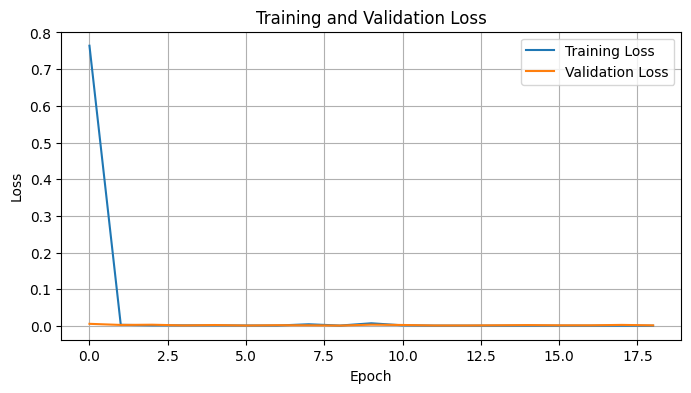

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
forecast_steps = 96*28
last_window_df = model_data[-window_size:]
input_window=scaler_X.transform(last_window_df[feature_columns]).reshape(1, window_size, -1)
predictions = []

for i in range(forecast_steps):
    # Predict demand
    pred_scaled = model.predict(input_window, verbose=0)
    pred = scaler_y.inverse_transform(pred_scaled)[0][0]
    predictions.append(pred)

        # Get features for next time step from test_df
    if i < len(model_data_test):
        next_features = model_data_test.iloc[i][feature_columns]
        next_input_scaled = scaler_X.transform([next_features.values])
    else:
        break  # No more feature rows in test_df

    # Slide window
    input_window = np.concatenate([input_window[0][1:], next_input_scaled], axis=0).reshape(1, window_size, -1)

    # print(input_window)
    

In [26]:
# predictions

In [27]:
future_index = model_data_test.index[:forecast_steps]
pred_df = pd.DataFrame({'datetime': future_index, 'predicted_demand': predictions})
pred_df.set_index('datetime', inplace=True)

# Combine with model_data_test
final_df = model_data_test.copy()
final_df = final_df.join(pred_df, how='left')


In [28]:
final_df.dropna()

,city_id,date_int,time_block,hour,iconcode,precipitation,pressurechange,pressuremeansealevel,relativehumidity,temperature,...,demand_rollmean_4,demand_rollmean_24,demand_rollmean_96,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,predicted_demand
37440,7,20250201,1,1,31.0,0.000,0.525,1013.850,81.950,11.15,...,1620.7175,1991.445417,1878.637187,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1546.177490
37441,7,20250201,2,1,31.0,0.000,0.250,1013.800,79.200,11.20,...,1593.3500,1966.268750,1878.469063,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1486.024536
37442,7,20250201,3,1,31.0,0.000,-0.025,1013.750,76.450,11.25,...,1571.8200,1938.633750,1878.414792,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1470.007446
37443,7,20250201,4,1,31.0,0.000,-0.300,1013.700,73.700,11.30,...,1555.5125,1909.175000,1878.475208,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1479.393066
37444,7,20250201,5,2,31.0,0.000,-0.450,1013.625,73.600,11.20,...,1543.0125,1878.675000,1878.610625,5.000000e-01,0.866025,-0.974928,-0.222521,0.866025,0.5,1489.296143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40123,7,20250228,92,23,12.0,3.400,1.400,1015.400,90.000,14.20,...,1515.7125,1816.598333,1698.302188,-2.588190e-01,0.965926,-0.433884,-0.900969,0.866025,0.5,1387.092529
40124,7,20250228,93,24,12.0,3.275,1.225,1015.175,91.625,14.30,...,1487.7125,1800.181667,1697.145938,-2.449294e-16,1.000000,-0.433884,-0.900969,0.866025,0.5,1357.739380
40125,7,20250228,94,24,12.0,3.150,1.050,1014.950,93.250,14.40,...,1463.5025,1782.086250,1695.990521,-2.449294e-16,1.000000,-0.433884,-0.900969,0.866025,0.5,1331.894531
40126,7,20250228,95,24,12.0,3.025,0.875,1014.725,94.875,14.50,...,1440.6400,1762.169167,1694.787188,-2.449294e-16,1.000000,-0.433884,-0.900969,0.866025,0.5,1308.132324


In [29]:
def daily_mape(group):
    return np.mean(np.abs((group['demand'] - group['predicted_demand']) / group['demand'])) * 100

# Compute daily MAPE
daily_mape_values = final_df.dropna().groupby('Date').apply(daily_mape)

In [30]:
daily_mape_values

Date
2025-02-01    2.757619
2025-02-02    4.604961
2025-02-03    3.575729
2025-02-04    2.942399
2025-02-05    3.514668
2025-02-06    2.879891
2025-02-07    2.495979
2025-02-08    7.406188
2025-02-09    7.860560
2025-02-10    8.037176
2025-02-11    6.989062
2025-02-12    7.665356
2025-02-13    7.374070
2025-02-14    3.552526
2025-02-15    4.085597
2025-02-16    2.942249
2025-02-17    2.781106
2025-02-18    2.120905
2025-02-19    2.478934
2025-02-20    3.354545
2025-02-21    2.303218
2025-02-22    2.532557
2025-02-23    3.500506
2025-02-24    2.961595
2025-02-25    2.771250
2025-02-26    3.357599
2025-02-27    4.070907
2025-02-28    5.396212
dtype: float64

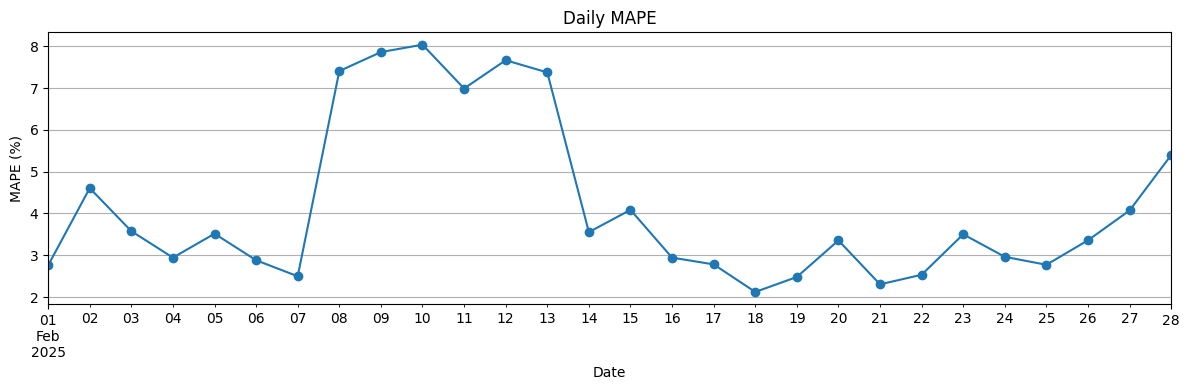

Average MAPE for February: 4.15%


In [31]:
import matplotlib.pyplot as plt
# Plot daily MAPE
plt.figure(figsize=(12, 4))
daily_mape_values.plot(marker='o')
plt.title("Daily MAPE")
plt.ylabel("MAPE (%)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print average MAPE over the month
print(f"Average MAPE for February: {daily_mape_values.mean():.2f}%")

In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_percentage_error

In [33]:
result=final_df.reset_index(drop=True).dropna()

In [34]:
result

,city_id,date_int,time_block,hour,iconcode,precipitation,pressurechange,pressuremeansealevel,relativehumidity,temperature,...,demand_rollmean_4,demand_rollmean_24,demand_rollmean_96,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,predicted_demand
0,7,20250201,1,1,31.0,0.000,0.525,1013.850,81.950,11.15,...,1620.7175,1991.445417,1878.637187,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1546.177490
1,7,20250201,2,1,31.0,0.000,0.250,1013.800,79.200,11.20,...,1593.3500,1966.268750,1878.469063,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1486.024536
2,7,20250201,3,1,31.0,0.000,-0.025,1013.750,76.450,11.25,...,1571.8200,1938.633750,1878.414792,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1470.007446
3,7,20250201,4,1,31.0,0.000,-0.300,1013.700,73.700,11.30,...,1555.5125,1909.175000,1878.475208,2.588190e-01,0.965926,-0.974928,-0.222521,0.866025,0.5,1479.393066
4,7,20250201,5,2,31.0,0.000,-0.450,1013.625,73.600,11.20,...,1543.0125,1878.675000,1878.610625,5.000000e-01,0.866025,-0.974928,-0.222521,0.866025,0.5,1489.296143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,7,20250228,92,23,12.0,3.400,1.400,1015.400,90.000,14.20,...,1515.7125,1816.598333,1698.302188,-2.588190e-01,0.965926,-0.433884,-0.900969,0.866025,0.5,1387.092529
2684,7,20250228,93,24,12.0,3.275,1.225,1015.175,91.625,14.30,...,1487.7125,1800.181667,1697.145938,-2.449294e-16,1.000000,-0.433884,-0.900969,0.866025,0.5,1357.739380
2685,7,20250228,94,24,12.0,3.150,1.050,1014.950,93.250,14.40,...,1463.5025,1782.086250,1695.990521,-2.449294e-16,1.000000,-0.433884,-0.900969,0.866025,0.5,1331.894531
2686,7,20250228,95,24,12.0,3.025,0.875,1014.725,94.875,14.50,...,1440.6400,1762.169167,1694.787188,-2.449294e-16,1.000000,-0.433884,-0.900969,0.866025,0.5,1308.132324


In [35]:
result['date'] = result['Date'].dt.date


In [36]:
result['date'] = result['Date'].astype(str)

# Optional: create 15-minute block numbers in a day (0–95)


# Filter February data only
feb_df = result[result['Date'].dt.month == 2]

# Get unique sorted February dates
feb_dates = sorted(feb_df['date'].unique())
num_days = len(feb_dates)

In [37]:
feb_dates

['2025-02-01',
 '2025-02-02',
 '2025-02-03',
 '2025-02-04',
 '2025-02-05',
 '2025-02-06',
 '2025-02-07',
 '2025-02-08',
 '2025-02-09',
 '2025-02-10',
 '2025-02-11',
 '2025-02-12',
 '2025-02-13',
 '2025-02-14',
 '2025-02-15',
 '2025-02-16',
 '2025-02-17',
 '2025-02-18',
 '2025-02-19',
 '2025-02-20',
 '2025-02-21',
 '2025-02-22',
 '2025-02-23',
 '2025-02-24',
 '2025-02-25',
 '2025-02-26',
 '2025-02-27',
 '2025-02-28']

In [38]:
titles = []
daily_dfs = []

for date in feb_dates:
    daily_data = feb_df[feb_df['Date'] == date]

    # ⬇️ Aggregate by time_block (average)
    daily_avg = daily_data.groupby('time_block')[['demand', 'predicted_demand']].mean().reset_index()
    daily_dfs.append(daily_avg)

    # Calculate MAPE after aggregation
    mape = mean_absolute_percentage_error(daily_avg['demand'], daily_avg['predicted_demand']) * 100
    titles.append(f"{date} (MAPE: {mape:.2f}%)")

# Subplot grid size
cols = 4
rows = (num_days + cols - 1) // cols

fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles)

# Add traces for each day's data
for idx, daily_df in enumerate(daily_dfs):
    row = (idx // cols) + 1
    col = (idx % cols) + 1

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['demand'],
        mode='lines',
        name='demand',
        line=dict(color='blue'),
        showlegend=(idx == 0)
    ), row=row, col=col)

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['predicted_demand'],
        mode='lines',
        name='Predicted',
        line=dict(color='red'),
        showlegend=(idx == 0)
    ), row=row, col=col)

# Update layout
fig.update_layout(
    height=300 * rows,
    width=1200,
    title_text="February Daily Predictions (Actual vs Predicted with MAPE)",
    legend=dict(x=1.02, y=1),
    margin=dict(t=80)
)

fig.show()


In [ ]:
# # --- Model Architecture ---
# model = Sequential([
#     Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
#     LayerNormalization(),

#     Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer='l2')),
#     LayerNormalization(),
#     Dropout(0.2),

#     Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer='l2')),
#     LayerNormalization(),
#     Dropout(0.2),

#     Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer='l2')),
#     Dropout(0.2),

#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])

# model.compile(optimizer='adam', loss=Huber())
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # --- Train the Model ---
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.1,
#     epochs=20,
#     batch_size=64,
#     callbacks=[early_stop],
#     verbose=1
# )

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# model = Sequential([
#     LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)